In [ ]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from PIL import Image

# Load image
image = Image.open("/content/sample_car.jpeg").convert("RGB")
# resize to 224x224
image = image.resize((224, 224))
# Load processor
processor = AutoImageProcessor.from_pretrained("facebook/deit-small-patch16-224")

# Load model with eager attention implementation
model = ViTForImageClassification.from_pretrained(
    "facebook/deit-small-patch16-224",
    attn_implementation="eager"
)

# Prepare input
inputs = processor(images=image, return_tensors="pt")

# Forward pass requesting attentions
outputs = model(**inputs, output_attentions=True, return_dict=True)
attentions = outputs.attentions

# Check attentions
print(attentions)  # Should now contain valid attention tensors instead of None


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

(tensor([[[[2.9039e-01, 6.0841e-03, 5.3831e-03,  ..., 5.7506e-03,
           5.9309e-03, 6.7211e-03],
          [4.1157e-01, 1.2966e-02, 1.1838e-02,  ..., 3.2874e-03,
           3.5707e-03, 4.5448e-03],
          [3.8976e-01, 1.4103e-02, 1.3562e-02,  ..., 3.1393e-03,
           3.4123e-03, 4.2559e-03],
          ...,
          [4.5662e-01, 3.1990e-03, 2.6065e-03,  ..., 1.1394e-02,
           1.0909e-02, 1.1874e-02],
          [4.4336e-01, 3.6626e-03, 2.9799e-03,  ..., 1.1132e-02,
           1.2181e-02, 1.2589e-02],
          [4.6034e-01, 3.9855e-03, 3.1761e-03,  ..., 9.7505e-03,
           1.0149e-02, 1.1654e-02]],

         [[8.7946e-01, 7.4034e-04, 5.5661e-04,  ..., 5.0604e-04,
           5.7192e-04, 6.7599e-04],
          [1.4927e-01, 1.9609e-02, 2.5953e-02,  ..., 4.2354e-03,
           4.6316e-03, 4.5210e-03],
          [1.4389e-01, 2.6056e-02, 2.1390e-02,  ..., 3.3877e-03,
           3.2725e-03, 5.0370e-03],
          ...,
          [1.8913e-01, 3.8996e-03, 3.0365e-03,  ..., 1.761

In [ ]:
last_attn = attentions[-1]  # shape: [1, num_heads, 197, 197]
# CLS token is index 0; we want its attention to all other tokens (1 to 196)
cls_attn = last_attn[0, :, 0, 1:]  # shape: [num_heads, 196]

In [ ]:
last_attn.shape

torch.Size([1, 6, 197, 197])

In [ ]:
mean_attn = cls_attn.mean(dim=0)  # shape: [196]

In [ ]:
mean_attn.shape

torch.Size([196])

In [ ]:
mean_attn

tensor([1.8110e-04, 1.8195e-02, 2.5040e-04, 4.3393e-02, 1.5476e-02, 4.7189e-04,
        1.2559e-02, 9.0046e-03, 2.5773e-03, 8.5098e-03, 3.0384e-02, 2.4492e-04,
        3.5923e-02, 1.1533e-04, 3.5336e-04, 1.7982e-04, 5.2771e-04, 2.8229e-04,
        2.7173e-04, 6.2341e-04, 3.8099e-04, 3.1499e-04, 4.9061e-04, 2.6928e-04,
        2.5809e-04, 2.1979e-04, 6.4452e-03, 4.0030e-04, 9.5051e-04, 7.9773e-04,
        4.9472e-04, 6.7962e-04, 2.7281e-04, 1.6067e-04, 2.8705e-03, 9.2093e-03,
        6.2528e-04, 3.4512e-04, 3.4943e-04, 8.6931e-04, 1.0844e-03, 8.3731e-04,
        2.8182e-03, 1.4172e-03, 1.1960e-03, 9.7483e-04, 7.2316e-04, 7.9690e-04,
        8.2659e-04, 6.0511e-04, 6.2814e-04, 8.4819e-04, 1.0403e-03, 1.0673e-03,
        8.5277e-04, 1.4572e-03, 6.0035e-03, 3.2855e-03, 2.2116e-03, 4.2959e-03,
        6.7142e-04, 1.1402e-04, 6.3221e-05, 1.3160e-03, 1.5532e-03, 5.0131e-05,
        4.8553e-04, 4.4271e-04, 8.7381e-04, 1.1927e-03, 7.3876e-04, 5.9492e-04,
        4.3765e-04, 3.6316e-04, 4.1571e-

In [ ]:
import math

patch_dim = int(math.sqrt(mean_attn.numel()))  # should yield 14
attn_map = mean_attn.reshape(patch_dim, patch_dim).detach().cpu().numpy()

In [ ]:
patch_dim

14

In [ ]:
attn_map.shape

(14, 14)

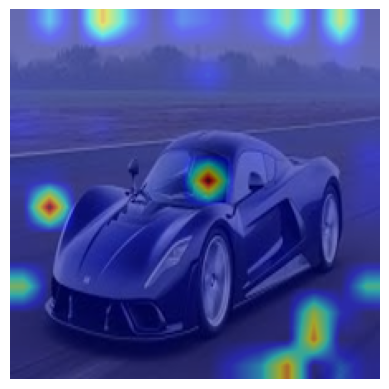

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Ensure the original image is 224×224
img_resized = image.resize((224, 224))

# Upsample attention map to image size
attn_resized = Image.fromarray(attn_map).resize((224, 224), resample=Image.BILINEAR)
attn_norm = np.array(attn_resized)
attn_norm = (attn_norm - attn_norm.min()) / (attn_norm.max() - attn_norm.min())

plt.imshow(img_resized)
plt.imshow(attn_norm, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Original Image:


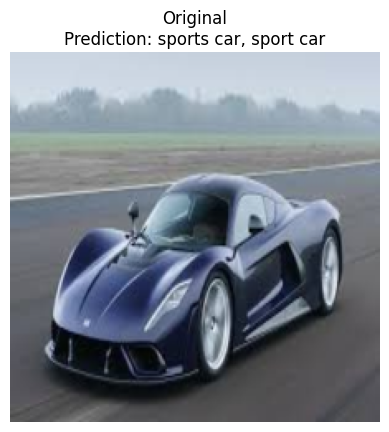

Random Masked (30% patches):


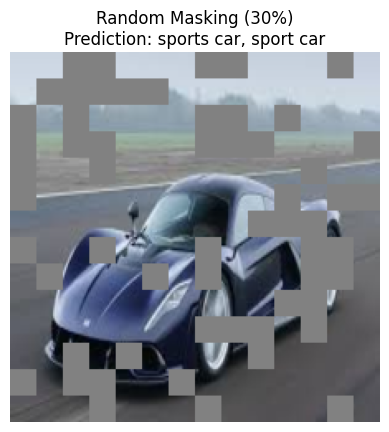

Center Masked (64x64 pixels):


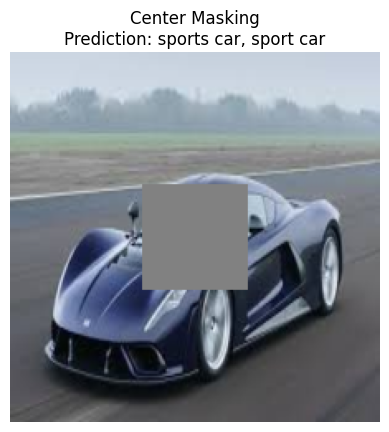

'sports car, sport car'

In [ ]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, ViTForImageClassification

# -----------------------------
# 1. Load model + image
# -----------------------------
image = Image.open("/content/sample_car.jpeg").convert("RGB")
processor = AutoImageProcessor.from_pretrained("facebook/deit-small-patch16-224")
model = ViTForImageClassification.from_pretrained("facebook/deit-small-patch16-224")

# Prepare input
inputs = processor(images=image, return_tensors="pt")

# -----------------------------
# 2. Helper functions for masking
# -----------------------------
def mask_random_patches(inputs, mask_ratio=0.3, patch_size=16):
    pixel_values = inputs["pixel_values"].clone()  # shape: [1, 3, 224, 224]
    _, _, H, W = pixel_values.shape
    num_patches = (H // patch_size) * (W // patch_size)

    # Choose random patches
    num_mask = int(mask_ratio * num_patches)
    mask_indices = np.random.choice(num_patches, num_mask, replace=False)

    for idx in mask_indices:
        row = (idx // (W // patch_size)) * patch_size
        col = (idx % (W // patch_size)) * patch_size
        pixel_values[:, :, row:row+patch_size, col:col+patch_size] = 0  # black patch

    return {"pixel_values": pixel_values}

def mask_center_patch(inputs, patch_size=16, mask_size=64):
    pixel_values = inputs["pixel_values"].clone()
    _, _, H, W = pixel_values.shape

    # Center square
    row_start, row_end = H//2 - mask_size//2, H//2 + mask_size//2
    col_start, col_end = W//2 - mask_size//2, W//2 + mask_size//2

    pixel_values[:, :, row_start:row_end, col_start:col_end] = 0
    return {"pixel_values": pixel_values}

# -----------------------------
# 3. Run inference + visualize
# -----------------------------
def predict_and_show(inputs, title):
    outputs = model(**inputs)
    pred_id = torch.argmax(outputs.logits, dim=-1).item()
    label = model.config.id2label[pred_id]

    # Convert tensor back to image
    img = inputs["pixel_values"][0].permute(1, 2, 0).detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize to [0,1]

    plt.imshow(img)
    plt.title(f"{title}\nPrediction: {label}")
    plt.axis("off")
    plt.show()
    return label

# -----------------------------
# 4. Compare cases
# -----------------------------
print("Original Image:")
predict_and_show(inputs, "Original")

print("Random Masked (30% patches):")
masked_random = mask_random_patches(inputs, mask_ratio=0.3)
predict_and_show(masked_random, "Random Masking (30%)")

print("Center Masked (64x64 pixels):")
masked_center = mask_center_patch(inputs, mask_size=64)
predict_and_show(masked_center, "Center Masking")


In [ ]:
# -----------------------------
# Step 1: Install dependencies (run once)
# -----------------------------
# !pip install datasets transformers scikit-learn

import torch
import numpy as np
from datasets import load_dataset
from transformers import ViTModel, AutoImageProcessor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# -----------------------------
# Step 2: Load CIFAR-10 dataset
# -----------------------------
dataset = load_dataset("cifar10")
train_data = dataset["train"].select(range(2000))  # small subset for speed
test_data = dataset["test"].select(range(500))

# -----------------------------
# Step 3: Load pretrained ViT
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
vit.eval()

# -----------------------------
# Step 4: Feature extraction
# -----------------------------
def extract_features(data, pooling="cls"):
    feats, labels = [], []
    for example in data:
        image, label = example["img"], example["label"]
        inputs = processor(image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vit(**inputs)
            last_hidden = outputs.last_hidden_state

            if pooling == "cls":
                emb = last_hidden[:, 0, :]  # CLS token
            elif pooling == "mean":
                emb = last_hidden[:, 1:, :].mean(dim=1)  # mean of patch tokens

        feats.append(emb.cpu().numpy())
        labels.append(label)

    return np.vstack(feats), np.array(labels)

# -----------------------------
# Step 5: Extract features
# -----------------------------
X_train_cls, y_train = extract_features(train_data, pooling="cls")
X_test_cls, y_test = extract_features(test_data, pooling="cls")

X_train_mean, _ = extract_features(train_data, pooling="mean")
X_test_mean, _ = extract_features(test_data, pooling="mean")

# -----------------------------
# Step 6: Train linear probes
# -----------------------------
clf_cls = LogisticRegression(max_iter=10).fit(X_train_cls, y_train)
clf_mean = LogisticRegression(max_iter=10).fit(X_train_mean, y_train)

acc_cls = accuracy_score(y_test, clf_cls.predict(X_test_cls))
acc_mean = accuracy_score(y_test, clf_mean.predict(X_test_mean))

print("Linear Probe (CLS token) Accuracy:", acc_cls)
print("Linear Probe (Mean pooling) Accuracy:", acc_mean)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe (CLS token) Accuracy: 0.964
Linear Probe (Mean pooling) Accuracy: 0.964


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Task4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from architecture import VAE

In [ ]:
# Dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

In [ ]:
# Train-validation split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
# Loss Function
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="sum")

    # KL Divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [ ]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
train_losses, val_losses = [], []

# Training Loop
for epoch in range(1, num_epochs + 1):
    # --- Training ---
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss, _, _ = vae_loss(recon_x, x, mu, logvar)
            val_loss += loss.item()
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch [1/10] Train Loss: 40.7773 | Val Loss: 29.2797
Epoch [2/10] Train Loss: 27.9050 | Val Loss: 26.6191
Epoch [3/10] Train Loss: 26.2045 | Val Loss: 25.7760
Epoch [4/10] Train Loss: 25.4683 | Val Loss: 25.2580
Epoch [5/10] Train Loss: 25.0312 | Val Loss: 24.7903
Epoch [6/10] Train Loss: 24.7255 | Val Loss: 24.6066
Epoch [7/10] Train Loss: 24.5004 | Val Loss: 24.5610
Epoch [8/10] Train Loss: 24.3168 | Val Loss: 24.3250
Epoch [9/10] Train Loss: 24.1800 | Val Loss: 24.2947
Epoch [10/10] Train Loss: 24.0061 | Val Loss: 24.0563


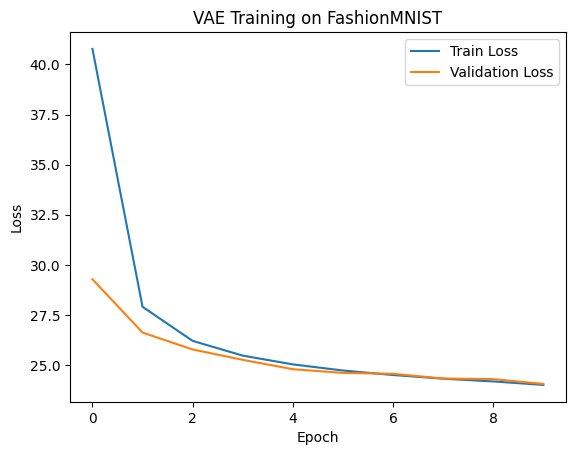

In [ ]:
# Plot Loss Curve
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training on FashionMNIST")
plt.show()

###Part 2

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, dataloader, device, n=6):
    model.eval()
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    with torch.no_grad():
        recon, mu, logvar = model(imgs)

    # Show originals (top) and reconstructions (bottom)
    fig, axes = plt.subplots(2, n, figsize=(n*1.5, 3))
    for i in range(n):
        # Original
        axes[0, i].imshow(imgs[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")
        # Reconstruction
        axes[1, i].imshow(recon[i].cpu().squeeze(), cmap="gray")
        axes[1, i].axis("off")
    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Recon", fontsize=12)
    plt.show()


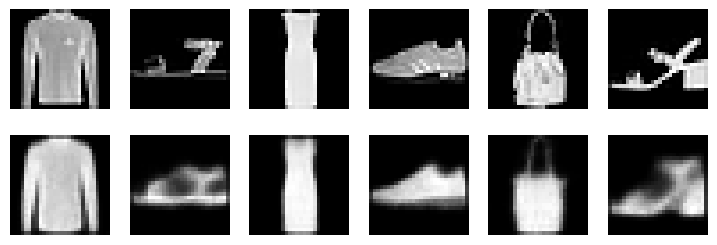

In [ ]:
visualize_reconstructions(model, val_loader, device, n=6)

In [ ]:
def visualize_generations(model, device, n=6):
    model.eval()
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(n, model.fc_mu.out_features).to(device)
        samples = model.decode(z)

    fig, axes = plt.subplots(1, n, figsize=(n*1.5, 1.5))
    for i in range(n):
        axes[i].imshow(samples[i].cpu().squeeze(), cmap="gray")
        axes[i].axis("off")
    plt.suptitle("Generations from N(0,I)", fontsize=14)
    plt.show()


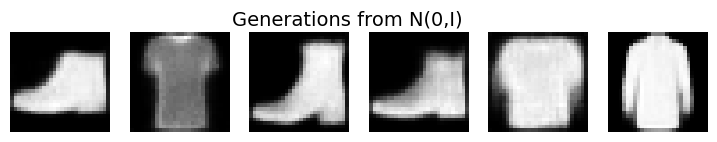

In [ ]:
visualize_generations(model, device, n=6)

In [ ]:
def visualize_laplacian_generations(model, device, n=6):
    model.eval()
    with torch.no_grad():
        # Laplace(0,1) sampling
        laplace = torch.distributions.Laplace(
            loc=torch.zeros(model.fc_mu.out_features),
            scale=torch.ones(model.fc_mu.out_features)
        )
        z = laplace.sample((n,)).to(device)
        samples = model.decode(z)

    fig, axes = plt.subplots(1, n, figsize=(n*1.5, 1.5))
    for i in range(n):
        axes[i].imshow(samples[i].cpu().squeeze(), cmap="gray")
        axes[i].axis("off")
    plt.suptitle("Generations from Laplace(0,1)", fontsize=14)
    plt.show()

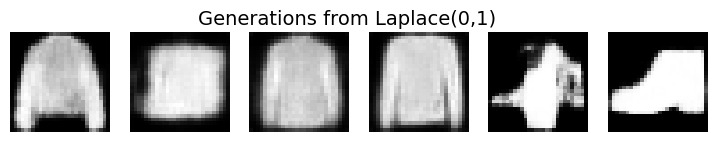

In [ ]:
visualize_laplacian_generations(model, device, n=6)